In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import glob
import sys
import os
df = pd.read_csv('Data_Entry_2017.csv')

c:\Users\jdori\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


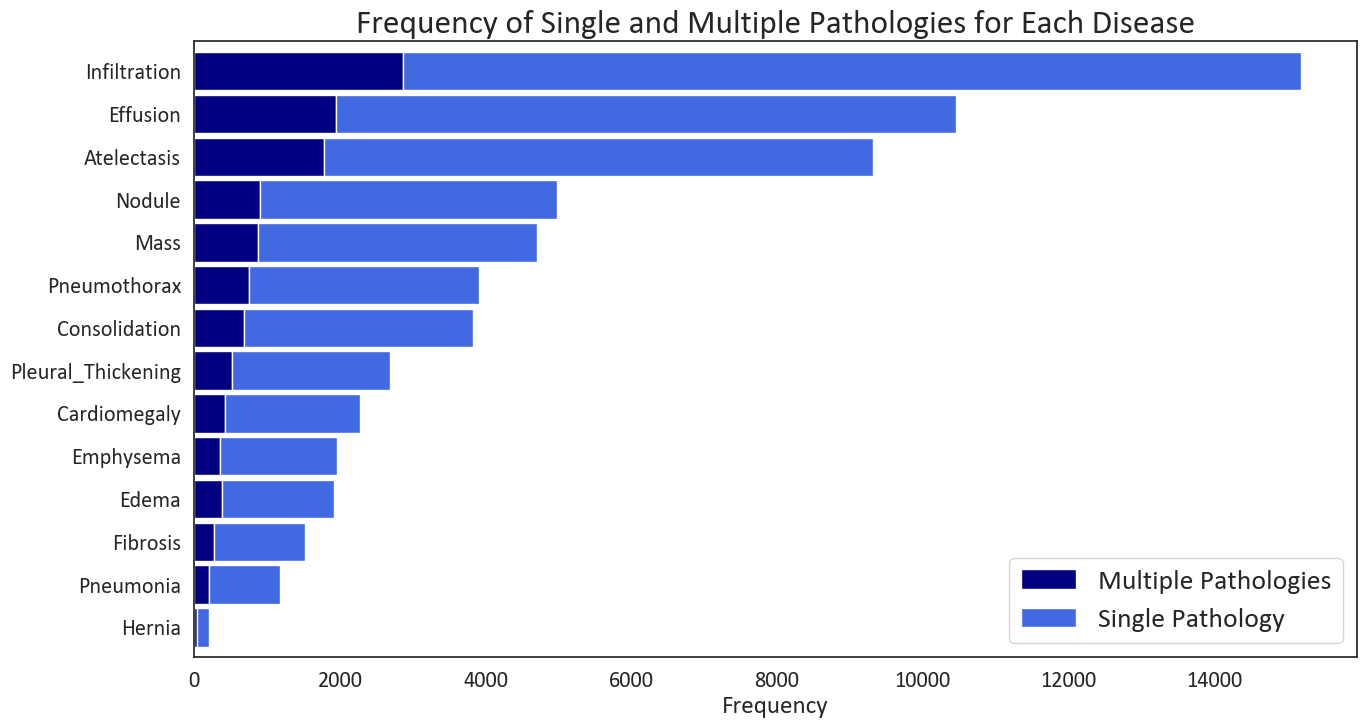

In [2]:
# Set the Seaborn style with no gridlines and a black border
sns.set(style='white', rc={"axes.grid": False, 'font.family': 'calibri'})

# Assuming your DataFrame is named df
# Split the 'Finding Labels' column and create a new column 'Num_labels'
df['Num_labels'] = df['Finding Labels'].apply(lambda x: len(str(x).split('|')))

# Create a new column 'Pathology_Type' to distinguish between single and multiple pathologies
df['Pathology_Type'] = df['Num_labels'].apply(lambda x: 'Single Pathology' if x == 1 else 'Multiple Pathologies')

# Create a new DataFrame to store the counts for each disease and pathology type
disease_counts = df['Finding Labels'].str.split('|', expand=True).stack().reset_index(level=0, drop=True).reset_index(name='Disease')

# Merge the original DataFrame with the new 'Disease' column
df_merged = pd.merge(df, disease_counts, left_index=True, right_index=True)

# Exclude entries with 'No Finding'
df_merged_filtered = df_merged[df_merged['Disease'] != 'No Finding']

# Count the occurrences of each disease and pathology type
counts = df_merged_filtered.groupby(['Disease', 'Pathology_Type']).size().unstack().fillna(0)

# Sort the counts by the lowest frequency
sorted_counts = counts.sum(axis=1).sort_values(ascending=True).index
counts = counts.loc[sorted_counts]

# Create a horizontal bar chart with different colors
ax = counts[['Multiple Pathologies', 'Single Pathology']].plot(kind='barh', stacked=True, figsize=(15, 8), color=['navy', 'royalblue'], width=0.9)
plt.title('Frequency of Single and Multiple Pathologies for Each Disease', fontsize = 24)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('')  # Remove the y-axis label
ax.tick_params(axis='both', labelsize=16)

# Move the legend to the bottom right inside the graph and make it bigger
plt.legend( bbox_to_anchor=(1, 0), loc='lower right', prop={'size': 20})

plt.show()

In [3]:
# Split the 'Findings' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# This will give you a new column 'Conditions' where each entry is a list of conditions

df['Num Conditions'] = df['Conditions'].apply(len)

df_exploded = df.explode('Conditions')

In [4]:
# Split the 'Finding Labels' column into separate conditions
df['Conditions'] = df['Finding Labels'].str.split('|')

# Convert the list of conditions to a string
df['Conditions'] = df['Conditions'].apply(lambda x: ' '.join(x))

# Create dummy variables for each condition
condition_dummies = df['Conditions'].str.get_dummies(sep=' ')

# Concatenate the original DataFrame with the dummy DataFrame
df = pd.concat([df, condition_dummies], axis=1)

In [5]:
# Select relevant columns
df = df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# Make sure the labels are of the string type
df['Finding Labels'] = df['Finding Labels'].astype(str)

# Split the labels into the different conditions
df['Finding Labels'] = df['Finding Labels'].str.split('|')

# The list of conditions
pathology_list = ['No Finding','Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

# Create new columns for each disease
for pathology in pathology_list:
    df[pathology] = df['Finding Labels'].apply(lambda x: int(pathology in x))

In [6]:
# Drop the 'Finding Labels' column
df = df.drop('Finding Labels', axis=1)

In [13]:
%%capture
for dirname, _, filenames in os.walk('E:/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) # Will not print (%%captured)
        
# Load the images
root_folder = "E:/archive"

# Use glob to get all PNG images from the subfolders
try:
    image_paths = glob.glob(os.path.join(root_folder, 'images_*/images/*.png'))
except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error, e.g., provide default paths or exit the program

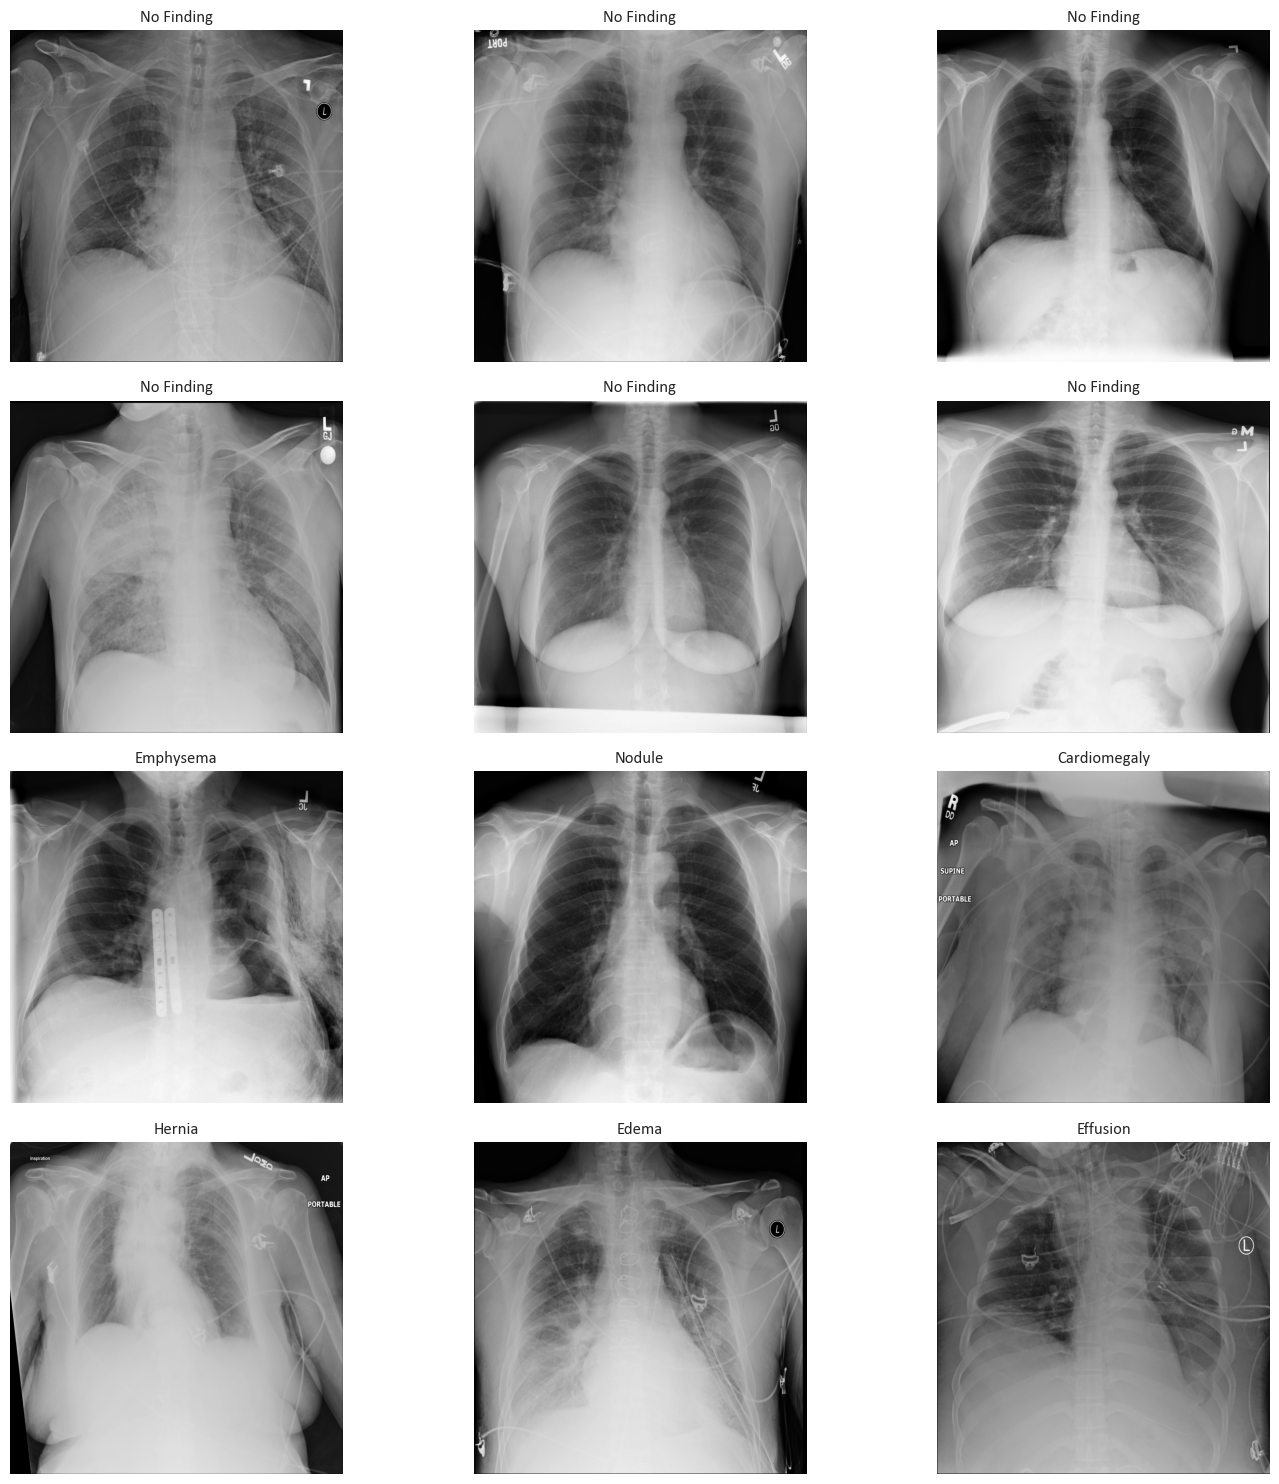

In [15]:
# Select 6 random pathologies
selected_pathologies = np.random.choice(pathology_list[1:], 6, replace=False)  # Exclude 'No Finding'

# Select one image from each selected pathology
other_pathology_images = [df[df[pathology] == 1].sample(1)['Image Index'].values[0] for pathology in selected_pathologies]

# Set aside 6 images from 'No Finding'
no_finding_images = df[df['No Finding'] == 1].sample(6)['Image Index'].values

# Now you have 6 images from 'No Finding' and 1 from each of the 6 selected pathologies
selected_images = list(no_finding_images) + other_pathology_images

image_paths_dict = {os.path.basename(path): path for path in image_paths}

# Create a figure with subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for i, img_name in enumerate(selected_images):
    try:
        # Load the image
        img_path = image_paths_dict[img_name]
        img = mpimg.imread(img_path)

        # Find the corresponding pathology
        pathology = df[df['Image Index'] == img_name][pathology_list].idxmax(axis=1).values[0]

        # Display the image in a subplot
        ax = axes[i // 3, i % 3]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(pathology)

    except KeyError:
        print(f"Error: Image not found in image_paths_dict - {img_name}")

# Remove empty subplots
if len(selected_images) < 12:
    for i in range(len(selected_images), 12):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()